# 1. Import

In [2]:
import os
import copy
from pathlib import Path
import pandas as pd

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot
from tqdm import tqdm
from rich.pretty import pprint

import dask.array as da
from dask.array.image import imread as imr
import matplotlib.pyplot as plt
from statistics import mean, stdev

/tmp/ipykernel_7348/4239023559.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
from correct_cells import * 

In [4]:
from bleach_correction import * 
from napari_bleach_correct.modules import *

# 2. Load Images

In [5]:
homeFolder = '/media/raphael/data/works/20231220_C3_14_2h_ofON/'
nameKey = 'C3.14_ON_01_w1SPI-488_s'

imsQ = '4'
cellNumber = '18'

nucleiStackForm = nameKey+imsQ+"_cell_"

pathToTimeSequenceFullView = homeFolder+nameKey+imsQ+'/*.tif'
cell_Crop_Folder = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/'
pathToTimeSequenceCell = homeFolder+nameKey+imsQ+'/cell_'+str(cellNumber)+'/*.tif'


sequenceCell = imr(pathToTimeSequenceCell)
mipSequenceCell = np.max(sequenceCell, axis=1)
MaxTimePoint = sequenceCell.shape[0]

In [8]:
full_movie= imr(pathToTimeSequenceFullView)

In [9]:
full_movie.shape

(120, 36, 1200, 1200)

In [9]:
viewer = napari.Viewer()
image_layer = viewer.add_image(
        mipSequenceCell, colormap='green' #maxImageCell
        )

In [10]:
ceilling = 1000

# 3. Get images informations 

In [11]:
images = viewer.layers[0].data


In [13]:
images.shape

(120, 198, 197)

## 3.1 Get intensity and erase clusters 

In [14]:
res = get_intensity(images)

In [15]:
res2 = res 
min_len = len(min(res2,key=len))

## 3.2 Mean and standard deviation 

In [18]:
mean_list=[]
for frame in res2:
    mean_list.append(mean(frame[:min_len]))

determiner une droite de forme ax + b ou exponentielle pour extraire une formule 

perte = (intensite intiale - intensite finale ) / intensite intiale 

In [19]:
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

creation moyenne mobile 

In [20]:
mv_avg = moving_avg(mean_list,40)

creation courbe de tendance 

In [21]:
y = np.arange(len(mean_list))
z = np.polyfit(y,mean_list,1)


In [22]:
import matplotlib.pyplot as plt
import numpy as np
def display_graph(mean_list,y,ceilling):
    # Liste des moyennes
    moyennes = mean_list

    # Création d'une liste pour les valeurs x (par exemple, des années)
    annees = y

    # Tracer les points moyens
    plt.scatter(annees, moyennes, color='blue', label='Moyennes')

    # Calculer la courbe de tendance linéaire
    coefficients = np.polyfit(annees, moyennes, 1)
    polynomial = np.poly1d(coefficients)
    tendance = polynomial(annees)


    # Tracer la courbe de tendance
    plt.plot(annees, tendance, color='red', label='Courbe de tendance')

    plt.plot(mv_avg,color='green',label='moyenne mobile')
    # Afficher l'équation de la courbe de tendance
    equation = f'Y = {coefficients[0]:.2f}X + {coefficients[1]:.2f}'
    plt.annotate(equation, xy=(2012, 20), fontsize=12, color='black')

    # Ajouter une légende et un titre
    plt.legend()
    plt.title('Courbe de tendance des moyennes')

    # Afficher le graphique
    plt.xlabel('Frames')
    plt.ylabel('Moyennes')
    
    plt.xlim(1, 123)  # Limite des axes x de 1 à 4
    plt.ylim(0, ceilling)  # Limite des axes y de 0 à 100
    plt.grid(True)
    plt.show()
    
    return equation, coefficients 


def exponential_curve(mean_list,etiquette):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Générer des données exponentielles aléatoires
    x =etiquette # Créer des valeurs x de 0 à 5
    y = mean_list  # Générer des valeurs y exponentielles avec un bruit aléatoire
    
    # Tracer les données
    #plt.scatter(x, y, label='Données')
    
    # Ajuster une courbe exponentielle aux données
    params = np.polyfit(x, np.log(y), 1,w=np.sqrt(y))
    a, b = params
    print(type(x))
    plt.plot(x, np.exp(a * x + b), color='red', label='Courbe de tendance exponentielle')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Courbe de tendance exponentielle')
    plt.show()


In [23]:
def exponential_curve(mean_list,etiquette,ceilling):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit

    # Données d'exemple (remplacez ces données par les vôtres)
    x_data = np.array(etiquette)
    y_data = np.array(mean_list)

    # Définition de la fonction exponentielle à ajuster
    def exponential_func(x, a, b):
        return a * np.exp(b * x)

    # Ajustement de la courbe exponentielle aux données
    popt, pcov = curve_fit(exponential_func, x_data, y_data)

    # Obtenir les paramètres ajustés
    a_fit, b_fit = popt

    # Génération des données pour la courbe ajustée
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = exponential_func(x_fit, a_fit, b_fit)

    # Traçage des données originales et de la courbe ajustée
    plt.scatter(x_data, y_data, label='Données')
    plt.plot(x_fit, y_fit, 'r-', label='Courbe de tendance exponentielle')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Courbe de tendance exponentielle')
    plt.legend()
    plt.grid(True)
    
    plt.xlim(1, 123)  # Limite des axes x de 1 à 4
    plt.ylim(0, ceilling)  # Limite des axes y de 0 à 100

    plt.show()


In [24]:
#exponential_curve(mean_list,y,ceilling)

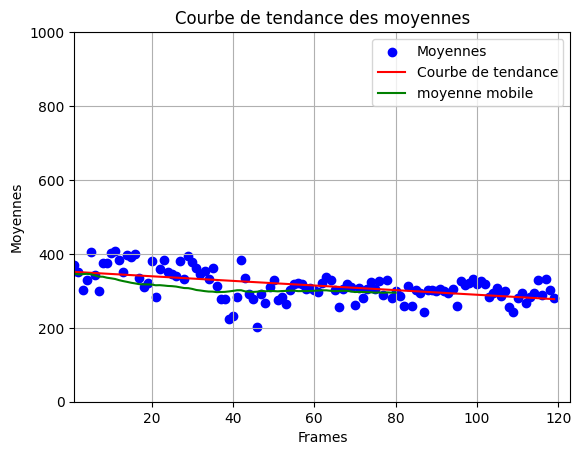

In [25]:
equation, c = display_graph(mean_list,y,ceilling)

In [26]:
equation

'Y = -0.63X + 351.95'

In [27]:
def get_facteur(c,start,stop):
    Y_0 = c[0]*start + c[1]
    Y_t = c[0]*stop + c[1]

    res = Y_t/Y_0

    return res 


print(get_facteur(c,0,123))

0.7815093491298356


In [28]:
np.savez(cell_Crop_Folder + 'mean_list.npz', mean_list)

In [29]:
((mean_list[0]/mean_list[1])-1)*100

-7.547169811320753

In [30]:
var_list = compute_var(mean_list)

Done
Done
Done
Done


In [31]:
np.savez(cell_Crop_Folder + 'var_list.npz', var_list)

std = np.std(mean_list)
std

## 4. Correct images 

In [10]:
corrected = exponential_correct(
        full_movie,contrast_limits=(0, 4095),method="bi")
#assert isinstance(corrected, np.ndarray)


INFO:napari_bleach_correct.modules.exponential:R-squared value for fitting a bi-exponential curve: dask.array<sub, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


In [11]:
corrected.shape

(120, 36, 1200, 1200)

In [34]:
viewer.add_image(
        np.max(corrected, axis=1), colormap='green' #maxImageCell
        )

<Image layer 'Image' at 0x7fd0ec02d070>

## 5. Display new graphs for corrected images

In [35]:
res = get_intensity(np.max(corrected, axis=1))
res2 = res 
min_len = len(min(res2,key=len))

In [36]:
mean_list=[]
for frame in res2:
    mean_list.append(mean(frame[:min_len]))

In [37]:
mv_avg = moving_avg(mean_list,40)

In [38]:
import matplotlib.pyplot as plt
import numpy as np
def trace_courbe_tendance(mean_list, ind_x, part): 
    # Données de base
    x = ind_x
    y = mean_list
    
    split = int(len(x)/part)
    for p in range (0,part) : 
        # Tracer la courbe de base
        plt.plot(x, y, label='Données originales')
    
    
        # Sélectionner une partie des données pour la courbe de tendance
        x_tendance = x[split*p:split*(p+1)]
        coeff = np.polyfit(x_tendance, y[split*p:split*(p+1)], 1)
        y_tendance = np.poly1d(coeff)(x_tendance)
        
        equation = f'Y = {x_tendance[0]:.2f}X + {x_tendance[1]:.2f}'
        plt.annotate(equation, xy=(2012, 20), fontsize=12, color='black')
        
        pente_m = (y_tendance[0] - y_tendance[-1]) / (x_tendance[0] - x_tendance[1]) 
        b = y_tendance[0]
        print('Y = ',pente_m,'X + ', b )
        print((y_tendance[-1])/y_tendance[0])
        # Tracer la courbe de tendance
        plt.plot(x_tendance, y_tendance, label='Courbe de tendance', linestyle='--')

        # Afficher la légende
        plt.legend()
        plt.grid()
        # Afficher le graphique
        plt.show()


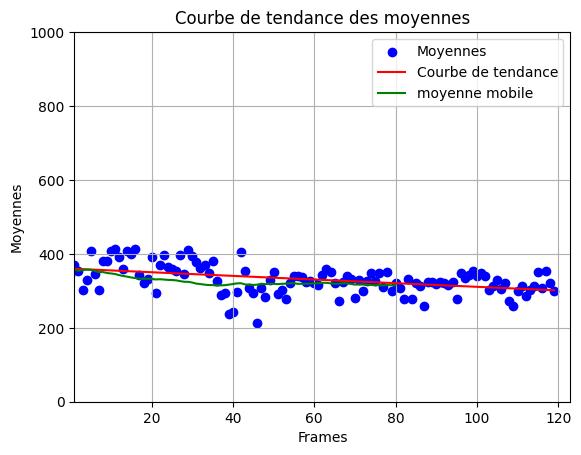

('Y = -0.49X + 360.18', array([ -0.49281547, 360.18085399]))

In [40]:
equation = display_graph(mean_list,y,ceilling) 
equation 

In [33]:
#y0 - yt / y0 

In [ ]:
save_layers(corrected, "C3.14_ON_01_w1SPI-488_s4_full_" )

Saving frame |███████████████████████████████████▍    | ▃▅▇ 106/120 [88%] in 14:

rmq : pour la cellule 23 on a facteur pour les trois tiers du film : 
p1 = 1.25
p2 = 0.85
p3 = 0.88 

developper une fonction pour appliquer ces facteurs successivement sur un meme film